For this task the gold labels for the test set are available. I made a function below to ease the process of loading the dataset. Feel free to use it. 

What to do:
- Hog transformation 
- Other preprocessing techniques
- A bit of cropping
- Apply all studied models + FFNN

# Packages, constants & functions

In [1]:
%%capture

utils = {
    'GridProperties.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/GridProperties.py',
    'GSModel.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/GSModel.py',
    'GridSearchParameters.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/GridSearchParameters.py'
}

RF_utils = {
    'RFGridProperties.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/RFModel/RFGridProperties.py',
    'RFSearchParameters.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/RFModel/RFSearchParameters.py',
    'RandomForestModel.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/RFModel/RandomForestModel.py'
}

SVM_utils = {
    'SVMGridProperties.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/SVMModel/SVMGridProperties.py',
    'SVMModel.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/SVMModel/SVMModel.py',
    'SVMSearchParameters.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/SVMModel/SVMSearchParameters.py'
}

DT_utils = {
    'DTGridProperties.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/DTModel/DTGridProperties.py',
    'DTModel.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/DTModel/DTModel.py',
    'DTSearchParameters.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/DTModel/DTSearchParameters.py'
}

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}



download_files(utils)
download_files(RF_utils)
download_files(SVM_utils)
download_files(DT_utils)

In [2]:
class DataProperties:
    num_classes = 10
    img_width = 28
    img_height = 28
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    translation = {
        0: 'T-shirt',
        1: 'Trouser', 
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal', 
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot'
    }

    def translate_labels(labels):
        return [DataProperties.translation[num] for num in labels]

In [3]:
%%capture 
!pip install nose

In [4]:
# Data download 
import numpy as np
from urllib.request import urlopen

# Testing
from nose.tools import assert_equal

# Model selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin

# My classes
from GridProperties import GridProperties
from GSModel import GSModel
from GridSearchParameters import GridSearchParameters

# RandomForest model
from RFGridProperties import RFGridProperties
from RFSearchParameters import RFSearchParameters
from RandomForestModel import RandomForestModel

# SVMModel
from SVMGridProperties import SVMGridProperties
from SVMSearchParameters import SVMSearchParameters
from SVMModel import SVMModel

# DecisionTreeModel
from DTGridProperties import DTGridProperties
from DTSearchParameters import DTSearchParameters
from DTModel import DTModel

In [5]:
def load_fashion_mnist():
    url_base = "https://www.math.unipd.it/~dasan/"
    Y_train = np.frombuffer(urlopen(url_base + "train-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_train = np.frombuffer(urlopen(url_base + "train-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_train), 784) # besides loadng 
                                                                                            #the data, I already flatten it into a vector
    Y_test = np.frombuffer(urlopen(url_base + "t10k-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_test = np.frombuffer(urlopen(url_base + "t10k-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_test), 784)

    return X_train, Y_train, X_test, Y_test

In [6]:
def plot_class(class_n, X, Y, figsize = (10, 10), matsize = (3, 3)):
    fig, axes = plt.subplots(matsize[0], matsize[1], figsize = figsize)
    fig.suptitle(f'Image of instances of Class №{class_n}')
    
    class_instances = X[Y == class_n]
    counter = 0
    for i in range(matsize[0]):
        for j in range(matsize[1]):
            axes[i, j].imshow(
                class_instances[counter].reshape(
                    DataProperties.img_height, 
                    DataProperties.img_width
                )
            )
            counter += 1

In [7]:
def compare_pixel_dist(X, Y, classes, sample_size):
    fig = plt.figure()
    for c in classes:
        sample = X[Y == c][:sample_size]
        sns.distplot(sample, hist = False, label = f'Class {c}')
    fig.legend()

In [8]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [9]:
def get_best_scores(cross_val_results):
    res = {}
    for name, cv_res in cross_val_results.items():
        res[name] = cv_res.best_score_
    return {k: v for k, v in sorted(res.items(), key = lambda item: item[1])}

def plot_best_scores(scores_dict, y_label, title):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylabel(y_label)
    ax.set_title(title)

    x_vals = best_scores.keys()
    y_vals = best_scores.values()
    
    ax.bar(x_vals, y_vals)
    plt.show()

In [10]:
def plot_cv_metrics(cross_val_res, metrics_name, figsize, layout_shape):
    n_models = len(cross_val_res)
    n_rows_cols = int(np.sqrt(n_models))
    
    fig, axes = plt.subplots(
        layout_shape[0],
        layout_shape[1],
        sharex = False,
        sharey = False,
        figsize = figsize
    )

    counter = 0
    for model_name, res in cross_val_res.items():
        row = counter % n_rows_cols
        col = counter // n_rows_cols
        
        if n_rows_cols == 1:
            ax = axes[counter]
        else:
            ax = axes[row, col]

        model_res = cross_val_res[model_name].cv_results_
        train_res = model_res['mean_train_' + metrics_name]
        test_res = model_res['mean_test_' + metrics_name]
        cv_epochs = np.arange(1, len(train_res) + 1)

        ax.bar(cv_epochs, train_res)
        ax.bar(cv_epochs, test_res)
        ax.set_title(f'Cross validation results for {model_name}')
        ax.set_xlabel('№ CV step')
        ax.set_ylabel(f'Metrics: {metrics_name}')

        ax.legend(['Train', 'Test'])

        counter += 1

In [11]:
def plot_confusion_matrix(model, model_name, X_test, Y_test):
    Y_pred = model.predict(X_test)
    cm = confusion_matrix(Y_test, Y_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix = cm,
        display_labels = DataProperties.translate_labels(model.classes_)
    )
    disp.plot()
    plt.title(f'Confusion matrix for {model_name}')
    plt.show()

# Data download

In [12]:
X_train, Y_train, X_test, Y_test = load_fashion_mnist()
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


# Data clean check

In [ ]:
# Check missing pixels
assert_equal(np.isnan(X_train).any(), False)
assert_equal(np.isnan(X_test).any(), False)
assert_equal(np.isnan(Y_train).any(), False)
assert_equal(np.isnan(Y_test).any(), False)

# Data exploration

### Class presence in Train & Test

- Make sure, that data is clean and does not contain missing pixels

In [ ]:
train_vals = np.unique(Y_train)
test_vals = np.unique(Y_test)
assert_equal((train_vals == test_vals).any(), True)
assert_equal(len(train_vals), DataProperties.num_classes)
assert_equal(len(test_vals), DataProperties.num_classes)

### Class balance

- We can see, that the distribution of classes is uniform in both train and test sets

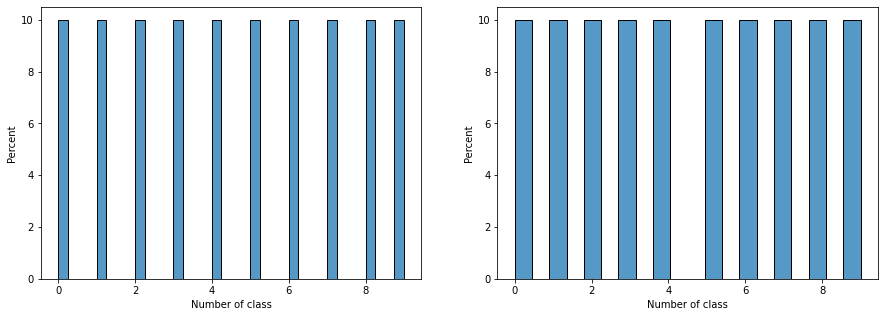

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
x_lab = 'Number of class'

axes[0].set(xlabel = x_lab)
axes[1].set(xlabel = x_lab)

sns.histplot(Y_train, ax = axes[0], stat = 'percent')
sns.histplot(Y_test, ax = axes[1], stat = 'percent')

### Image uniformity

- Here we check greyscale value distribution, to see if it depends on the class. This is done for further data processing, e.g. standartization
- Conclusions:
    - Min = 0, Max = 255 (Greyscale value)
    - Distribution of greyscale value is bimodal. Two modes:
        - ~0
        - ~220-230
    - Big difference in modes' amplitude -> it is reasonable to preprocess images with standartization / scaling

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

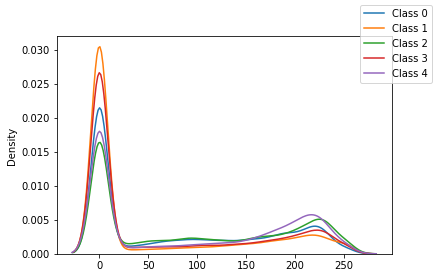

In [ ]:
compare_pixel_dist(X_train, 
                   Y_train,
                   classes = DataProperties.classes[:5],
                   sample_size = 150
)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

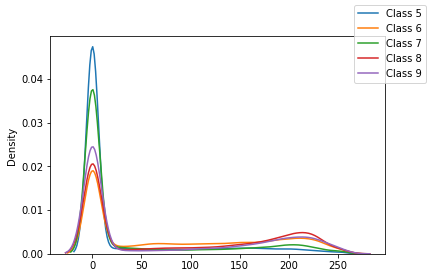

In [ ]:
compare_pixel_dist(X_train, 
                   Y_train,
                   classes = DataProperties.classes[5:],
                   sample_size = 150
)

### Image visualization

- Visualize images of clothes, related to class numbers from 0 to 9
- Conclusions:
    - Class 0: T-Shirts
    - Class 1: Trousers
    - Class 2: Pull-overs
    - Class 3: Dresses
    - Class 4: Jackets
    - Class 5: Women hills
    - Class 6: Shirts
    - Class 7: Sports shoes
    - Class 8: Luggage & Backpacks
    - Class 9: Shoes

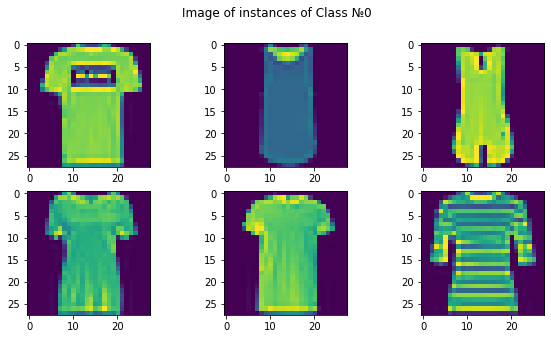

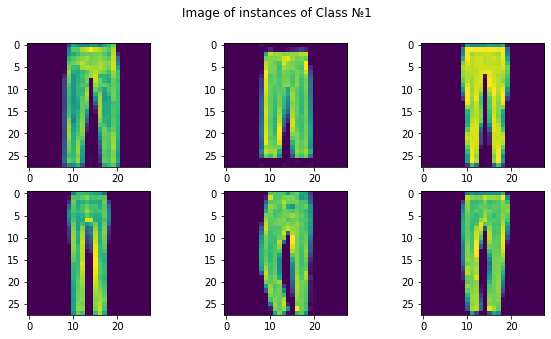

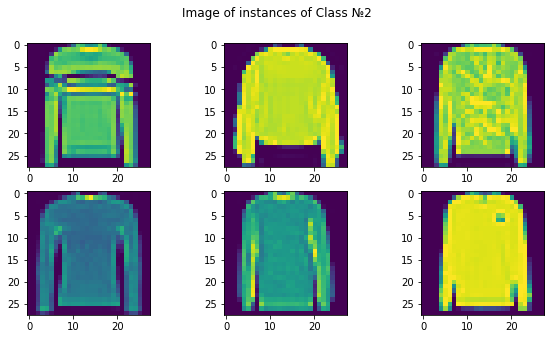

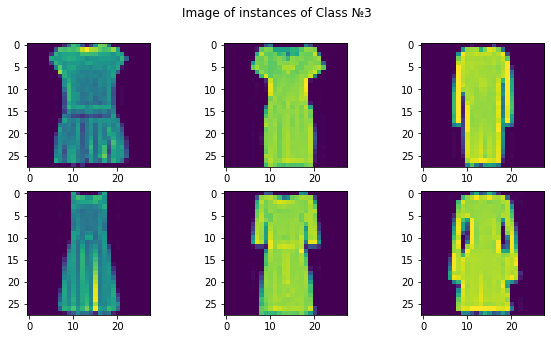

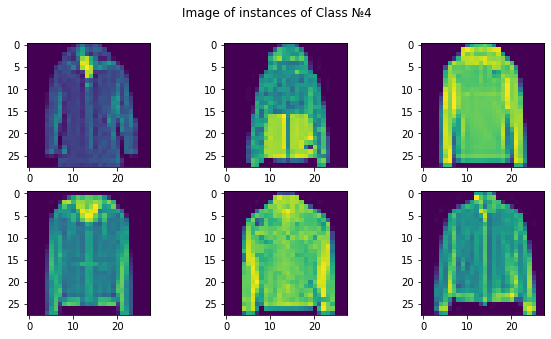

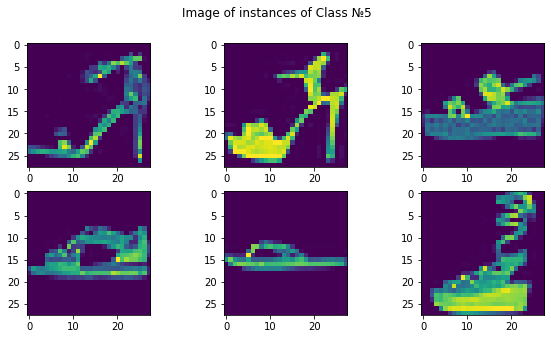

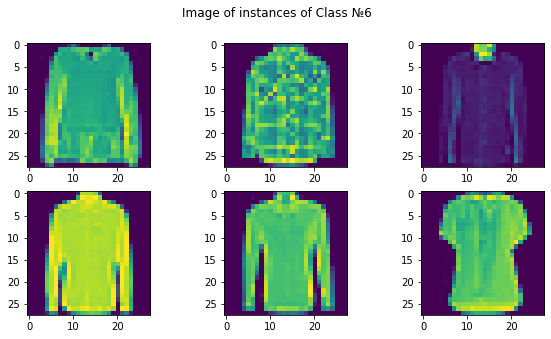

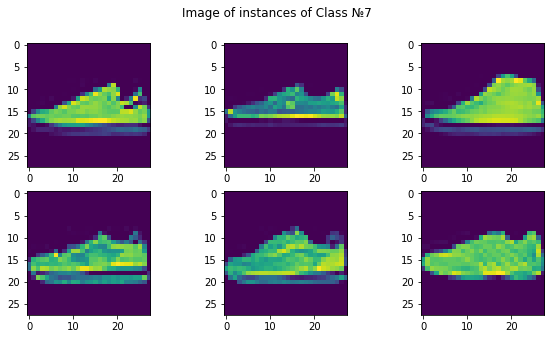

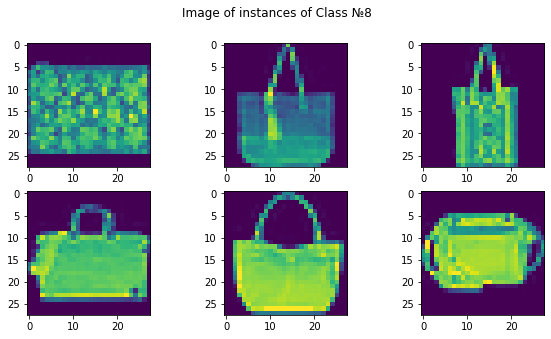

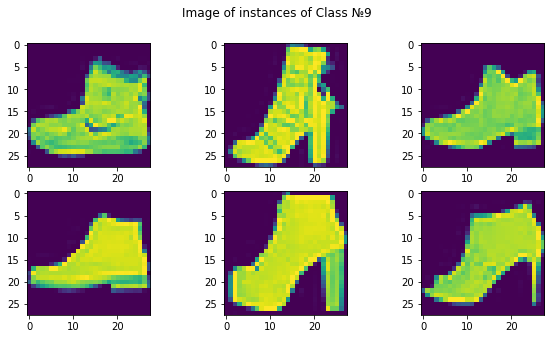

In [ ]:
for class_n in range(10):
    plot_class(
        class_n,
        X = X_train,
        Y = Y_train,
        figsize = (10, 5),
        matsize = (2, 3)
    )

# Data preprocessing

- Conclusions:
    - Clean dataset (No NAN values)
    - Images as input (No subdivision on categorical, data -> no preprocessing with encoding)
    - No color channel (Gray images, already flattened)
- After applying preprocessing, we can see:
    - How it changes distribution of pixels brightness
    - How it affects visual perception of the image

### Preprocessing

In [13]:
preproc_pipeline = Pipeline(
    [
        # ('hog', HogTransformer()),
        ('scaler', StandardScaler())
    ]
)

X_train = preproc_pipeline.fit_transform(X_train)
X_test = preproc_pipeline.transform(X_test)

### Visualization after preprocessing

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

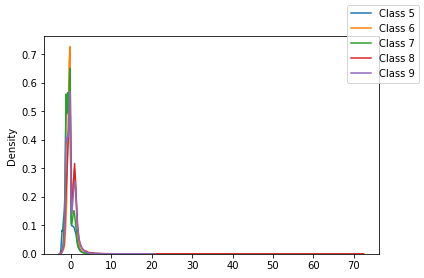

In [14]:
# Distribution changed after preprocessing
compare_pixel_dist(X_train, 
                   Y_train,
                   classes = DataProperties.classes[5:],
                   sample_size = 150
)

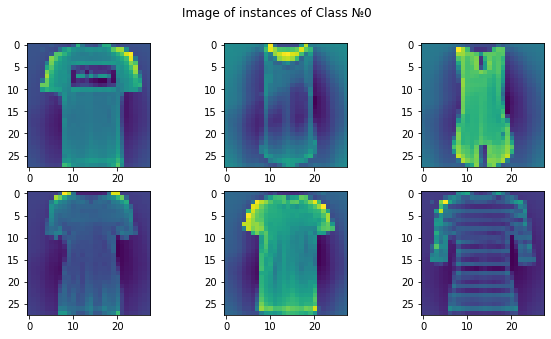

In [15]:
plot_class(
    0,
    X = X_train,
    Y = Y_train,
    figsize = (10, 5),
    matsize = (2, 3)
)

# Model training

- I tried to take advantage of OOP approach, for clear and transparent code. To avoid redundancy, all search procedures and parameter grids are encapsulated inside classes, inherited from GSModel (Grid Search Model) class
- Resulting models will be compared based on several metrics for multiclass classification:
    - Accuracy
    - ROC-AUC
    - F1 
    - Precision & Recall
    - Confusion matrix analysis
- Cross validation parameters for compared models are kept identical:
    - [TODO:]

### Models Training (Cross Validation)

In [18]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

scorers = {
    'Accuracy': make_scorer(accuracy_score),
    # 'F1': make_scorer(f1_score)
    #'ROC-AUC': make_scorer(roc_auc_score)
}

models = [
    RandomForestModel(),  # Random forest
    SVMModel(),  # SVM
    DTModel()  # Decision tree
]

cv_results = {}

for model in models:
    clf = GridSearchCV(
        model.clf,
        model.get_grid(),
        scoring = scorers,  # Several metrics to track
        refit = 'Accuracy',  # Score used to find best parameters (among several metrics)
        return_train_score = True,  # Explore train behaviour
        **model.get_search_parameters()
    )
    clf.fit(X_train[:200], Y_train[:200])
    cv_results.update({model.name: clf})

# Model comparison

### Best score comparison

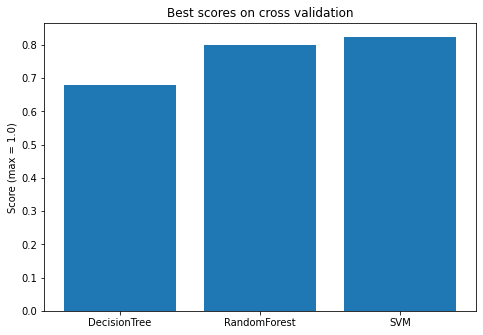

In [19]:
best_scores = get_best_scores(cv_results)
plot_best_scores(
    best_scores,
    y_label = 'Score (max = 1.0)',
    title = 'Best scores on cross validation'
)

### Average CV train & CV test performance

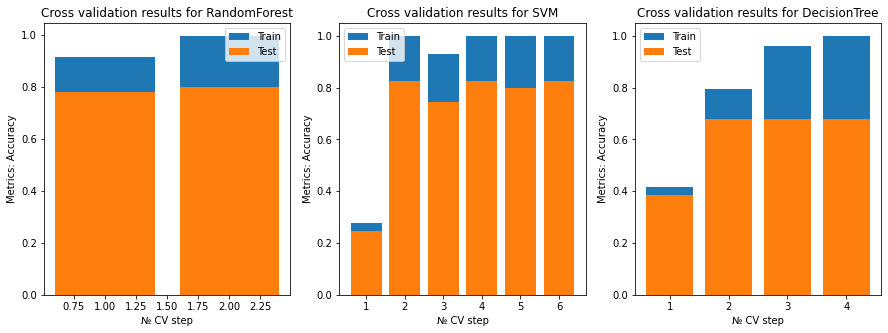

In [21]:
plot_cv_metrics(
    cv_results,
    metrics_name = 'Accuracy',
    figsize = (15, 5),
    layout_shape = (1, 3)
)

### Learning curves comparison

### Confusion matrix analysis

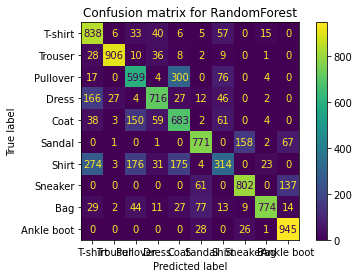

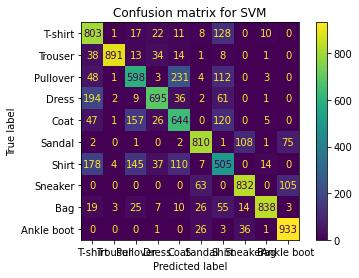

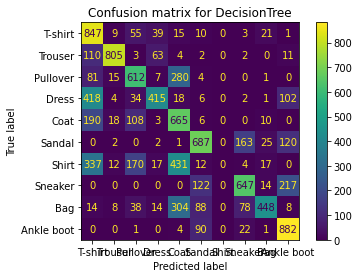

In [22]:
for model_name, model in cv_results.items():
    plot_confusion_matrix(
        model,
        model_name,
        X_test,
        Y_test
    )

# Neural network approach